**THIS IS NOT FINANCIAL ADVICE. DO YOUR OWN RESEARCH. USE AT YOUR OWN RISK.**

In [1]:
# Parameters
ticker_symbol = "MSFT"

In [2]:
# Parameters
ticker_symbol = "AMZN"


In [3]:
# For more information on this notebook, see my blog posts:
# https://medium.com/wwblog/technical-analysis-of-investment-prices-with-python-fe44fcdbceea
# https://medium.com/wwblog/using-papermill-to-auto-generate-technical-analyses-for-investments-19900e518f9e

import pandas as pd
import pandas_ta as ta
import yfinance as yf
import requests_cache
import matplotlib.pyplot as plt
import mplfinance as mpf

from IPython.display import display, Markdown, Latex
from matplotlib.lines import Line2D

# In the blog post, I included the various prep and plot functions directly in the notebook itself.
# But I'm moving these to external scripts to avoid cluttering up the technical analysis with a bunch of code.
# Work in progress.

# Functions to prepare the data frame for various technical analyses
%run prepare_df.py

# Functions to plot the data for various technical analyses
%run plot_df.py

In [4]:
session = requests_cache.CachedSession("yfinance.cache")
session.headers["User-Agent"] = f"ta-{ticker_symbol}-notebook/1.0"
ticker = yf.Ticker(ticker_symbol, session=session)
ticker_short_name = ticker.info["shortName"]
display(Markdown(f"# Technical analysis: {ticker_short_name} ({ticker_symbol})"))

# Technical analysis: Amazon.com, Inc. (AMZN)

## 1 Load data

In [5]:
hist = ticker.history(start=date_ranges["2Y"], end=today_str)
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-29,1864.000000,1874.750000,1855.020020,1858.000000,2088000,0,0
2020-01-30,1858.000000,1872.869995,1850.609985,1870.680054,6327400,0,0
2020-01-31,2051.469971,2055.719971,2002.270020,2008.719971,15567300,0,0
2020-02-03,2010.599976,2048.500000,2000.250000,2004.199951,5891700,0,0
2020-02-04,2029.880005,2059.800049,2015.369995,2049.669922,5289300,0,0


## 2 Candlestick charts

See [Candlestick definition](https://www.investopedia.com/terms/c/candlestick.asp) for more information.

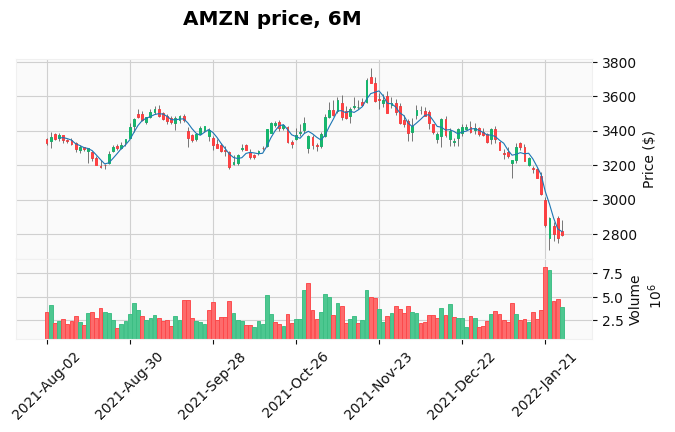

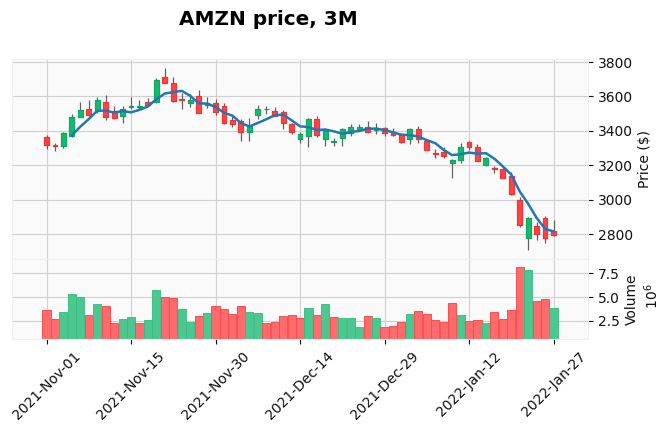

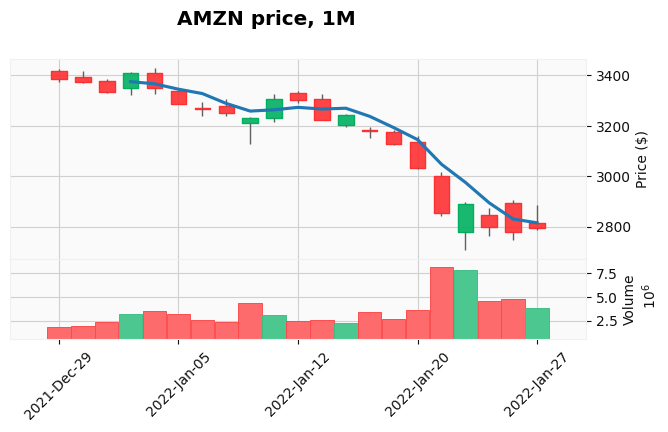

In [6]:
for rng in ["6M", "3M", "1M"]:
    plot_candlestick(hist, ticker_symbol, rng)

## 3 Capital appreciation

See [Capital Appreciation](https://www.investopedia.com/terms/c/capitalappreciation.asp) for more information.

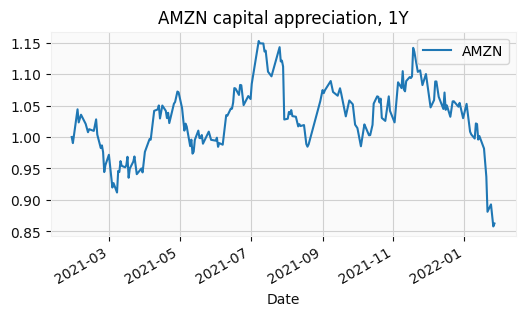

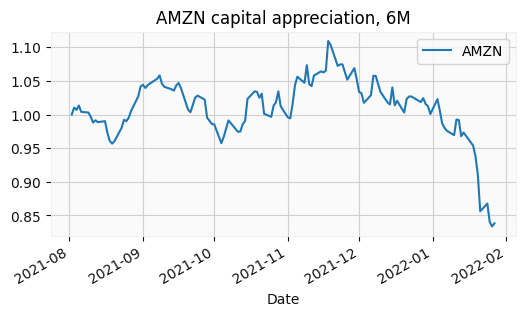

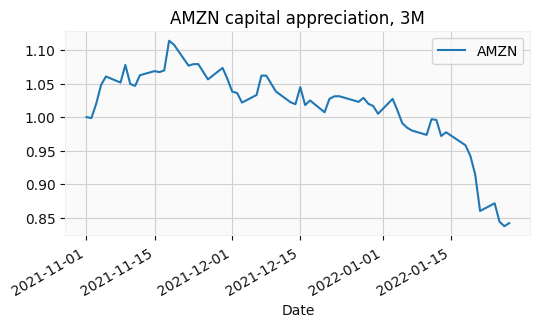

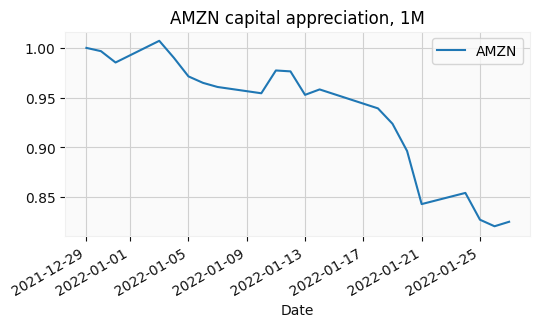

In [7]:
for rng in ["1Y", "6M", "3M", "1M"]:
    plot_capital_appreciation(hist, ticker_symbol, rng)

## 4 Trend indicators

See:

- [Trend Trading](https://www.investopedia.com/terms/t/trendtrading.asp)

### 4.1 Simple Moving Average Crossover

See [How to Use a Moving Average to Buy Stocks](https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp).

In [8]:
def plot_crossover(rng):
    start = date_ranges[rng]
    end = today_str
    hist[start:end][["Close", "SMA_50", "SMA_200"]].plot(
        title=f"{ticker_symbol} SMA Crossover, {rng}",
        style=["-", "-", "--"],
        figsize=(6, 3))

In [9]:
hist["SMA_50"] = hist["Close"].rolling(50).mean()
hist["SMA_200"] = hist["Close"].rolling(200).mean()

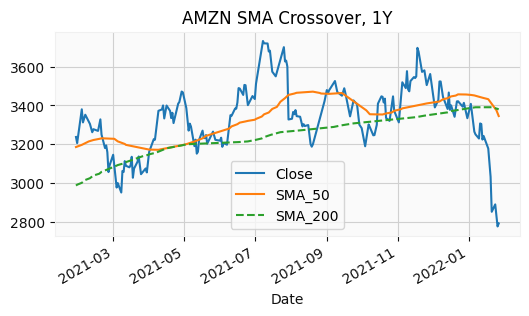

In [10]:
plot_crossover("1Y")

## 5 Volatility indicators

### 5.1 Bollinger Bands

See [Bollinger Band](https://www.investopedia.com/terms/b/bollingerbands.asp) for more information.

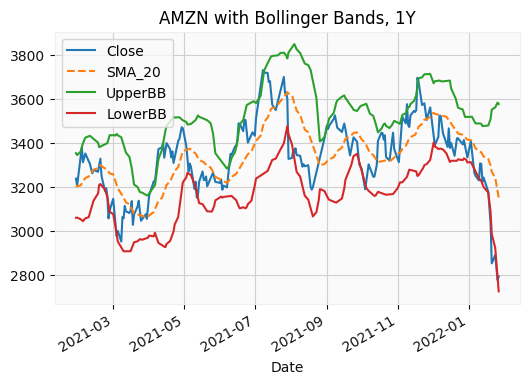

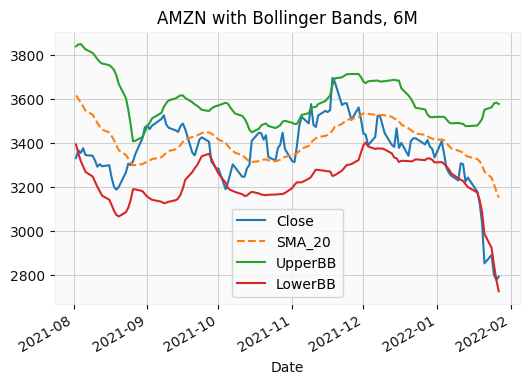

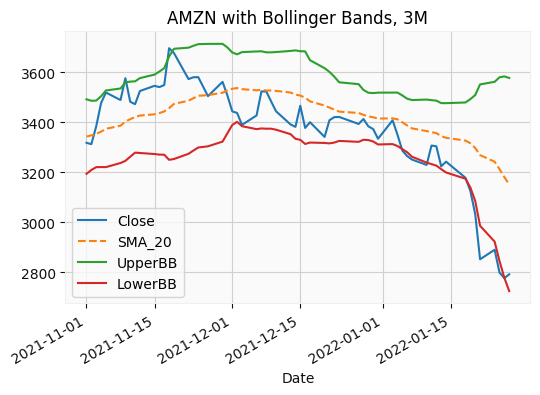

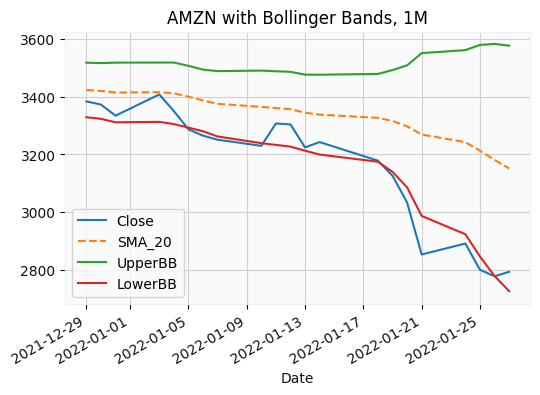

In [11]:
df = add_bollinger_bands(hist)
for rng in ["1Y", "6M", "3M", "1M"]:
    plot_bollinger(df, ticker_symbol, rng)

## 6 Momentum indicators

See [Momentum indicators](https://www.investopedia.com/investing/momentum-and-relative-strength-index/) for more information.

### 6.1 Stochastic Oscillator

See [Stochastic Oscillator](https://www.investopedia.com/terms/s/stochasticoscillator.asp) for more information.

In [12]:
# rng: date range: 1M, 3M, 6M, 1Y
def add_stochastic_oscillator(periods=14):
    high_roll = hist["High"].rolling(periods).max()
    low_roll = hist["Low"].rolling(periods).min()
    
    # Fast stochastic indicator
    hist["%K"] = 100 * ((hist["Close"] - low_roll) / (high_roll - low_roll))
    
    # Slow stochastic indicator
    hist["%D"] = hist["%K"].rolling(3).mean()


def plot_stochastic_oscillator(rng, periods=14):
    start = date_ranges[rng]
    end = today_str
    temp_df = hist[start:end]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(6, 6))

    ax[0].set_title(f"{ticker_symbol} price, {rng}")
    ax[0].plot(temp_df["Close"], color="tab:blue")

    ax[1].set_title(f"{ticker_symbol} Stochastic Oscillator ({periods}-day period), {rng}")
    ax[1].set_ylim(-10, 110)
    ax[1].plot(temp_df["%K"], color="tab:blue") # fast
    ax[1].plot(temp_df["%D"], color="tab:orange") # slow

    ax[1].axhline(80, color="tab:red", ls="--")
    ax[1].axhline(20, color="tab:green", ls="--")

    custom_lines = [
        Line2D([0], [0], color="tab:blue", lw=4),
        Line2D([0], [0], color="tab:orange", lw=4),
        Line2D([0], [0], color="tab:red", lw=4),
        Line2D([0], [0], color="tab:green", lw=4),
    ]
    ax[1].legend(custom_lines, ["%K", "%D", "Overbought", "Oversold"], loc="best")

In [13]:
add_stochastic_oscillator()

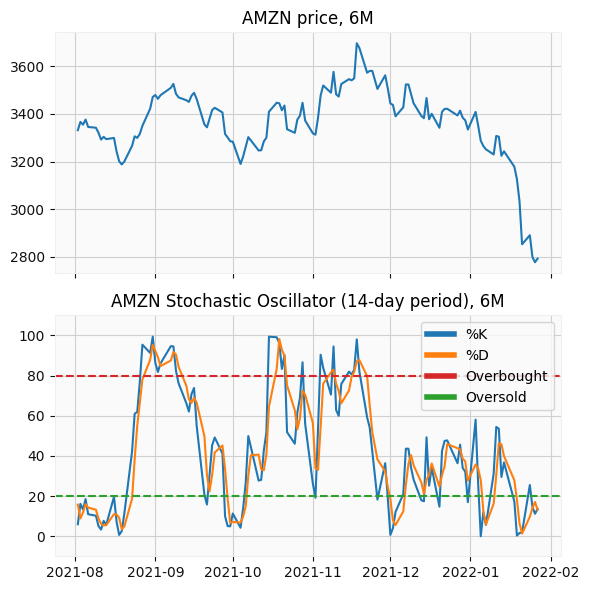

In [14]:
plot_stochastic_oscillator("6M")

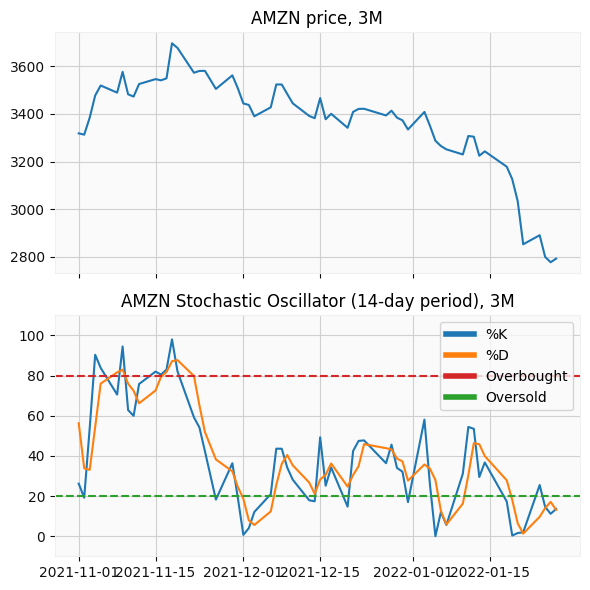

In [15]:
plot_stochastic_oscillator("3M")

### 6.2 Relative Strength Index (RSI)

See [Relative Strength Index (RSI)](https://www.investopedia.com/terms/r/rsi.asp) for more information.

In [16]:
# https://www.roelpeters.be/many-ways-to-calculate-the-rsi-in-python-pandas/
def add_rsi(periods=14):
    close_diff = hist["Close"].diff()
    up = close_diff.clip(lower=0)
    down = -1 * close_diff.clip(upper=0)

    ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100 / (1 + rsi))
    hist["RSI"] = rsi


def plot_rsi(rng, periods=14):
    start = date_ranges[rng]
    end = today_str
    temp_df = hist[start:end]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(6, 6))

    ax[0].set_title(f"{ticker_symbol} price, {rng}")
    ax[0].plot(temp_df["Close"])

    ax[1].set_title(f"{ticker_symbol} RSI ({periods}-day moving average), {rng}")
    ax[1].set_ylim(0, 100)
    ax[1].plot(temp_df["RSI"])
    ax[1].axhline(70, color="tab:red", ls="--")
    ax[1].axhline(30, color="tab:green", ls="--")

    custom_lines = [
        Line2D([0], [0], color="tab:red", lw=4),
        Line2D([0], [0], color="tab:green", lw=4)
    ]
    ax[1].legend(custom_lines, ["Overbought", "Oversold"], loc="best")

In [17]:
add_rsi()

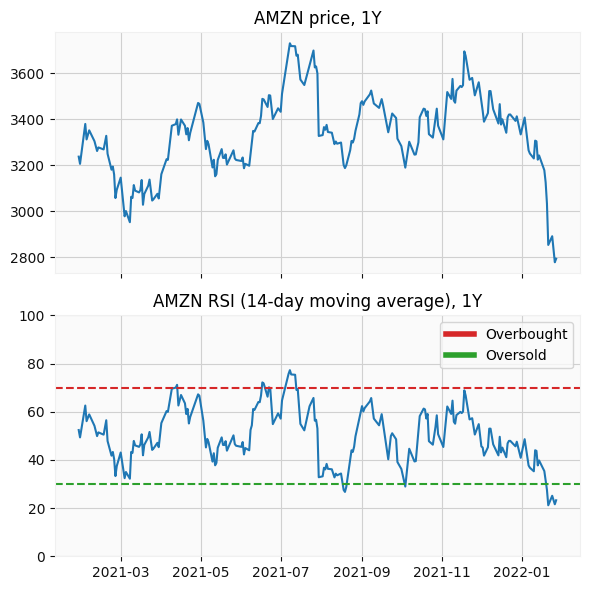

In [18]:
plot_rsi("1Y")

### 6.3 Moving Average Convergence Divergence (MACD)

See:

- [Moving Average Convergence Divergence (MACD)](https://www.investopedia.com/terms/m/macd.asp)
- [What Is the Moving Average Convergence Divergence, and How Is It Calculated?](https://www.investopedia.com/ask/answers/122414/what-moving-average-convergence-divergence-macd-formula-and-how-it-calculated.asp)
- [MACD: A Primer](https://www.investopedia.com/trading/macd/)


In [19]:
def add_macd():
    ema_12 = hist["Close"].ewm(span=12, adjust=False, min_periods=12).mean()
    ema_26 = hist["Close"].ewm(span=26, adjust=False, min_periods=26).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False, min_periods=9).mean()
    diff = macd - signal
    
    hist["MACD"] = macd
    hist["MACD-s"] = signal
    hist["MACD-h"] = diff
    

def plot_macd(rng, periods=14):
    start = date_ranges[rng]
    end = today_str
    temp_df = hist[start:end]
    
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, tight_layout=True, figsize=(6, 6))

    ax[0].set_title(f"{ticker_symbol} price, {rng}")
    ax[0].plot(temp_df["Close"])

    ax[1].set_title(f"{ticker_symbol} MACD, {rng}")
    ax[1].plot(temp_df["MACD"], color="tab:blue") # slow signal
    ax[1].plot(temp_df["MACD-s"], color="tab:orange") # fast signal
    ax[1].bar(temp_df.index, height=temp_df["MACD-h"], color="black") # diff

    custom_lines = [
        Line2D([0], [0], color="tab:blue", lw=4),
        Line2D([0], [0], color="tab:orange", lw=4),
        Line2D([0], [0], color="black", lw=4)
    ]
    ax[1].legend(custom_lines, ["MACD", "Signal", "Diff"], loc="best")

In [20]:
add_macd()

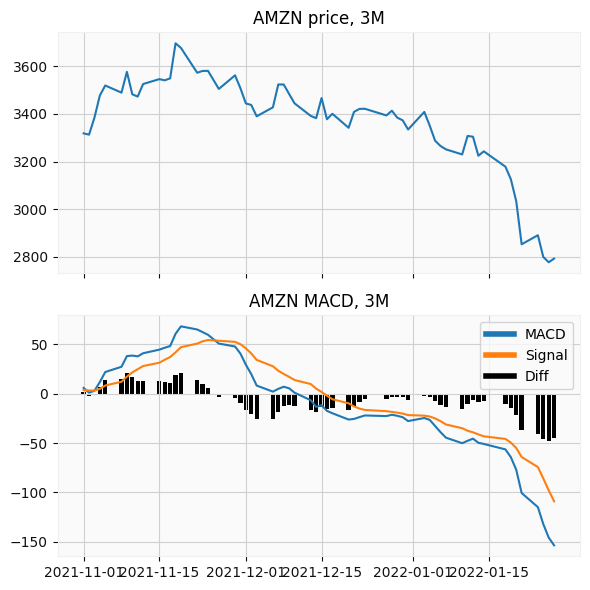

In [21]:
plot_macd("3M")